# WBF approach over TTA for single model Resnest Fasterrcnn

Hi everyone!

This is my first open kernel which use TTA for resnest fastrrcnn.

My resnest fasterrcnn is based on torchvision's fasterrcnn.

If it is helpful, please upvote my kernel

# Main Idea

This kernel is based on https://www.kaggle.com/shonenkov/wbf-over-tta-single-model-efficientdet

# Dependencies

In [1]:
!pip install --no-deps '../input/timm-package/timm-0.1.26-py3-none-any.whl' > /dev/null
!pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null

In [2]:
import sys
sys.path.insert(0, "../input/omegaconf")
sys.path.insert(0, "../input/weightedboxesfusion")
sys.path.insert(0, "../input/resnest/pytorch-image-models-master/pytorch-image-models-master")

import ensemble_boxes
import torch
import torchvision
from  torchvision.models.utils import load_state_dict_from_url
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.ops import misc as misc_nn_ops
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from matplotlib import pyplot as plt
from collections import OrderedDict
from torch import nn
import warnings
from torch.jit.annotations import Tuple, List, Dict, Optional
from timm.models.resnest import resnest101e
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import gc

DIR_INPUT = '/kaggle/input/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

DIR_WEIGHTS = '/kaggle/input/resnest'

WEIGHTS_FILE = f'{DIR_WEIGHTS}/best-model-sgd-cos.bin'

In [3]:
def get_valid_transforms():
    return A.Compose([
            A.Resize(height=1024, width=1024, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [4]:
DATA_ROOT_PATH = '../input/global-wheat-detection/test'

class DatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [5]:
dataset = DatasetRetriever(
    image_ids=np.array([path.split('/')[-1][:-4] for path in glob(f'{DATA_ROOT_PATH}/*.jpg')]),
    transforms=get_valid_transforms()
)

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    drop_last=False,
    collate_fn=collate_fn
)

In [6]:
class CrossEntropyLabelSmooth(nn.Module):
    """Cross entropy loss with label smoothing regularizer.

    Reference:
    Szegedy et al. Rethinking the Inception Architecture for Computer Vision. CVPR 2016.
    Equation: y = (1 - epsilon) * y + epsilon / K.

    Args:
        num_classes (int): number of classes.
        epsilon (float): weight.
    """
    def __init__(self, num_classes, epsilon=0.1, use_gpu=True):
        super(CrossEntropyLabelSmooth, self).__init__()
        self.num_classes = num_classes
        self.epsilon = epsilon
        self.use_gpu = use_gpu
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, inputs, targets):
        """
        Args:
            inputs: prediction matrix (before softmax) with shape (batch_size, num_classes)
            targets: ground truth labels with shape (num_classes)
        """
        log_probs = self.logsoftmax(inputs)
        targets = torch.zeros(log_probs.size()).scatter_(1, targets.unsqueeze(1).data.cpu(), 1)
        if self.use_gpu: targets = targets.cuda()
        targets = (1 - self.epsilon) * targets + self.epsilon / self.num_classes
        loss = (- targets * log_probs).mean(0).sum()
        return loss

In [7]:
def fastrcnn_loss(class_logits, box_regression, labels, regression_targets):
    # type: (Tensor, Tensor, List[Tensor], List[Tensor]) -> Tuple[Tensor, Tensor]
    """
    Computes the loss for Faster R-CNN.
    Arguments:
        class_logits (Tensor)
        box_regression (Tensor)
        labels (list[BoxList])
        regression_targets (Tensor)
    Returns:
        classification_loss (Tensor)
        box_loss (Tensor)
    """

    labels = torch.cat(labels, dim=0)
    regression_targets = torch.cat(regression_targets, dim=0)
    labal_smooth_loss = CrossEntropyLabelSmooth(2)
    classification_loss = labal_smooth_loss(class_logits, labels)

    # get indices that correspond to the regression targets for
    # the corresponding ground truth labels, to be used with
    # advanced indexing
    sampled_pos_inds_subset = torch.nonzero(labels > 0).squeeze(1)
    labels_pos = labels[sampled_pos_inds_subset]
    N, num_classes = class_logits.shape
    box_regression = box_regression.reshape(N, -1, 4)

    box_loss = det_utils.smooth_l1_loss(
        box_regression[sampled_pos_inds_subset, labels_pos],
        regression_targets[sampled_pos_inds_subset],
        beta=1 / 9,
        size_average=False,
    )
    box_loss = box_loss / labels.numel()

    return classification_loss, box_loss

In [8]:
def resnest_fpn_backbone(pretrained, norm_layer=misc_nn_ops.FrozenBatchNorm2d, trainable_layers=3):
    # resnet_backbone = resnet.__dict__['resnet152'](pretrained=pretrained,norm_layer=norm_layer)
    backbone = resnest101e(pretrained=pretrained)
    # select layers that wont be frozen
    assert trainable_layers <= 5 and trainable_layers >= 0
    layers_to_train = ['layer4', 'layer3', 'layer2', 'layer1', 'conv1'][:trainable_layers]
    # freeze layers only if pretrained backbone is used
    for name, parameter in backbone.named_parameters():
        if all([not name.startswith(layer) for layer in layers_to_train]):
            parameter.requires_grad_(False)
    return_layers = {'layer1': '0', 'layer2': '1', 'layer3': '2', 'layer4': '3'}
    in_channels_stage2 = backbone.inplanes // 8
    in_channels_list = [
        in_channels_stage2,
        in_channels_stage2 * 2,
        in_channels_stage2 * 4,
        in_channels_stage2 * 8,
    ]
    out_channels = 256
    return BackboneWithFPN(backbone, return_layers, in_channels_list, out_channels)

In [9]:
class WheatDetector(torch.nn.Module):
    def __init__(self, trainable_layers=3, **kwargs):
        super(WheatDetector, self).__init__()
        backbone = resnest_fpn_backbone(pretrained=False)
        self.base = FasterRCNN(backbone, num_classes = 2, **kwargs)
        self.base.roi_heads.fastrcnn_loss = fastrcnn_loss

    def forward(self, images, targets=None):
        return self.base(images, targets)

In [10]:
def load_net(checkpoint_path):
    model = WheatDetector()

    # Load the trained weights
    checkpoint=torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])


    del checkpoint
    gc.collect()

    model.eval();
    return model.cuda()

net = load_net(WEIGHTS_FILE)

# Custom TTA API

Idea is simple: 
- `augment` make tta for one image
- `batch_augment` make tta for batch of images
- `deaugment_boxes` return tta predicted boxes in back to original state of image

Also we are interested in `Compose` with combinations of tta :)

In [11]:
class BaseWheatTTA:
    """ author: @shonenkov """
    image_size = 1024

    def augment(self, image):
        raise NotImplementedError
    
    def batch_augment(self, images):
        raise NotImplementedError
    
    def deaugment_boxes(self, boxes):
        raise NotImplementedError

class TTAHorizontalFlip(BaseWheatTTA):
    """ author: @shonenkov """

    def augment(self, image):
        return image.flip(1)
    
    def batch_augment(self, images):
        return images.flip(2)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [1,3]] = self.image_size - boxes[:, [3,1]]
        return boxes

class TTAVerticalFlip(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return image.flip(2)
    
    def batch_augment(self, images):
        return images.flip(3)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,2]] = self.image_size - boxes[:, [2,0]]
        return boxes
    
class TTARotate90(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 1, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 1, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = self.image_size - boxes[:, [3,1]] 
        res_boxes[:, [1,3]] = boxes[:, [0,2]]
        return res_boxes

class TTACompose(BaseWheatTTA):
    """ author: @shonenkov """
    def __init__(self, transforms):
        self.transforms = transforms
        
    def augment(self, image):
        for transform in self.transforms:
            image = transform.augment(image)
        return image
    
    def batch_augment(self, images):
        for transform in self.transforms:
            images = transform.batch_augment(images)
        return images
    
    def prepare_boxes(self, boxes):
        result_boxes = boxes.copy()
        result_boxes[:,0] = np.min(boxes[:, [0,2]], axis=1)
        result_boxes[:,2] = np.max(boxes[:, [0,2]], axis=1)
        result_boxes[:,1] = np.min(boxes[:, [1,3]], axis=1)
        result_boxes[:,3] = np.max(boxes[:, [1,3]], axis=1)
        return result_boxes
    
    def deaugment_boxes(self, boxes):
        for transform in self.transforms[::-1]:
            boxes = transform.deaugment_boxes(boxes)
        return self.prepare_boxes(boxes)

# Demonstration how it works:

In [12]:
def process_det(index, outputs, score_threshold=0.5):
    boxes = outputs[index]['boxes'].data.cpu().numpy()   
    scores = outputs[index]['scores'].data.cpu().numpy()
    boxes = (boxes).clip(min=0, max=1023).astype(int)
    indexes = np.where(scores>score_threshold)
    boxes = boxes[indexes]
    scores = scores[indexes]
    return boxes, scores

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


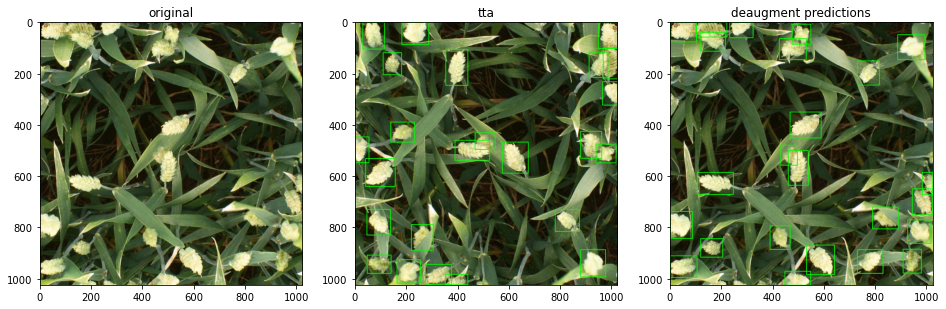

In [13]:
# you can try own combinations:
transform = TTACompose([
    TTARotate90(),
    TTAVerticalFlip(),
    TTAHorizontalFlip(),
])

fig, ax = plt.subplots(1, 3, figsize=(16, 6))

image, image_id = dataset[5]

numpy_image = image.permute(1,2,0).cpu().numpy().copy()

ax[0].imshow(numpy_image);
ax[0].set_title('original')

tta_image = transform.augment(image)
tta_image_numpy = tta_image.permute(1,2,0).cpu().numpy().copy()

outputs = net(tta_image.unsqueeze(0).float().cuda())
boxes, scores = process_det(0, outputs)

for box in boxes:
    cv2.rectangle(tta_image_numpy, (box[0], box[1]), (box[2],  box[3]), (0, 1, 0), 2)

ax[1].imshow(tta_image_numpy);
ax[1].set_title('tta')
    
boxes = transform.deaugment_boxes(boxes)

for box in boxes:
    cv2.rectangle(numpy_image, (box[0], box[1]), (box[2],  box[3]), (0, 1, 0), 2)
    
ax[2].imshow(numpy_image);
ax[2].set_title('deaugment predictions');

# Combinations of TTA

In [14]:
from itertools import product

tta_transforms = []
for tta_combination in product([TTAHorizontalFlip(), None], 
                               [TTAVerticalFlip(), None],
                               [TTARotate90(), None]):
    tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))

# WBF over TTA:

In [15]:
def make_tta_predictions(images, score_threshold=0.5):
    with torch.no_grad():
        images = torch.stack(images).float().cuda()
        predictions = []
        for tta_transform in tta_transforms:
            result = []
            outputs = net(tta_transform.batch_augment(images.clone()))

            for i, image in enumerate(images):
                boxes = outputs[i]['boxes'].data.cpu().numpy()   
                scores = outputs[i]['scores'].data.cpu().numpy()
                indexes = np.where(scores > score_threshold)[0]
                boxes = boxes[indexes]
                boxes = tta_transform.deaugment_boxes(boxes.copy())
                result.append({
                    'boxes': boxes,
                    'scores': scores[indexes],
                })
            predictions.append(result)
    return predictions

def run_wbf(predictions, image_index, image_size=1024, iou_thr=0.5, skip_box_thr=0.43, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist() for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist() for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).astype(int).tolist() for prediction in predictions]
    boxes, scores, labels = ensemble_boxes.ensemble_boxes_wbf.weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

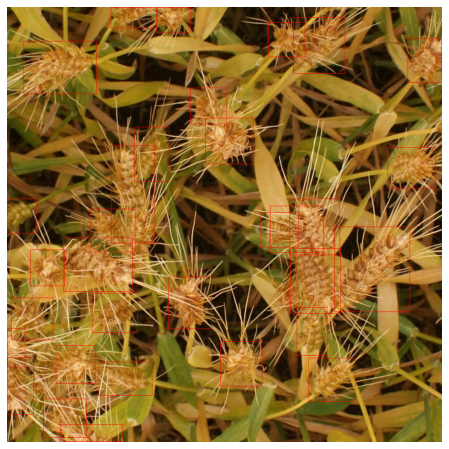

In [16]:
import matplotlib.pyplot as plt

for j, (images, image_ids) in enumerate(data_loader):
    break

predictions = make_tta_predictions(images)

i = 1
sample = images[i].permute(1,2,0).cpu().numpy()

boxes, scores, labels = run_wbf(predictions, image_index=i)
boxes = boxes.round().astype(np.int32).clip(min=0, max=1023)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 1)

ax.set_axis_off()
ax.imshow(sample);

# Inference

In [17]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
    return " ".join(pred_strings)

In [18]:
results = []

for images, image_ids in data_loader:
    predictions = make_tta_predictions(images)
    for i, image in enumerate(images):
        boxes, scores, labels = run_wbf(predictions, image_index=i)
        boxes = boxes.round().astype(np.int32).clip(min=0, max=1023)
        image_id = image_ids[i]

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        results.append(result)

In [19]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.to_csv('submission.csv', index=False)
test_df.head()

,image_id,PredictionString
0,cc3532ff6,0.9988 773 828 164 161 0.9988 263 641 100 170 ...
1,796707dd7,0.9945 771 517 177 200 0.9943 896 330 112 96 0...
2,53f253011,0.9977 625 105 114 137 0.9971 21 599 118 143 0...
3,51f1be19e,0.9967 612 86 154 169 0.9958 73 694 124 217 0....
4,f5a1f0358,0.9977 938 432 84 190 0.9972 139 747 163 127 0...


# Thank you for reading my kernel!